# Librerias

Esta celda importa todas las librerías utilizadas para el procesamiento de imágenes, manipulación de datos, entrenamiento de modelos y visualización.

In [ ]:
import os
from typing import Optional, Callable
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import csv
import random
from itertools import combinations
from collections import defaultdict
import gdown
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import gc
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import seaborn as sns

# Carga del Dataset desde Google Drive

Esta celda:

- Detecta si el entorno es Google Colab o local (`using_colab`).
- Monta Google Drive si estás en Colab.
- Descarga el archivo ZIP del dataset de Los Simpsons desde una URL de Drive usando `gdown`.
- Extrae el contenido del ZIP en la carpeta destino (`REPO_PATH`).
- Define las rutas al dataset de imágenes y al archivo de anotaciones (`annotation.txt`).

In [ ]:
# Configura si se está usando Colab o local
using_colab = False  # ← Cambia esto a True si estás en Colab

if using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    REPO_PATH = "/content/drive/MyDrive/Data/simpsons_dataset"
else:
    REPO_PATH = "."

# Descargar el zip del dataset
url = "https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub"
output = os.path.join(REPO_PATH, "simpsons_dataset.zip")

print(f"Descargando dataset desde Drive a: {output}")
gdown.download(url, output, quiet=False)

# Descomprimir el ZIP principal
print(f"Extrayendo: {output}")
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(REPO_PATH)

# Ruta final al dataset
DATASET_PATH = os.path.join(REPO_PATH, "simpson_dataset")
ANNOTATION_FILE = os.path.join(REPO_PATH, "annotation.txt")

Descargando dataset desde Drive a: ./simpsons_dataset.zip


Downloading...
From (original): https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub
From (redirected): https://drive.google.com/uc?id=1TIX9pzPF7HvXuupRGiZUZr80Jg15_qub&confirm=t&uuid=e5ed1088-2c5d-430e-87ce-79121121896a
To: /content/simpsons_dataset.zip
100%|██████████| 1.16G/1.16G [00:21<00:00, 54.9MB/s]


Extrayendo: ./simpsons_dataset.zip


# División del dataset y generación de tripletas para entrenamiento

Esta celda contiene dos funciones clave:
- Lee el archivo `annotation.txt` con anotaciones originales (ruta, bounding box y clase).
- Filtra entradas inválidas o etiquetas con pocas imágenes.
- Divide el dataset en un conjunto de entrenamiento y otro de testeo (`train_test_split`).
- Guarda ambos subconjuntos en formato `.csv` (`annotations_train.csv`, `annotations_test.csv`).

In [ ]:
def split_annotations(annotation_path, root_dir, train_output, test_output, test_size=0.2):
    label_to_entries = defaultdict(list)

    with open(annotation_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) != 6:
                print(f"[!] Línea ignorada (formato incorrecto): {line.strip()}")
                continue
            path, x1, y1, x2, y2, label = parts

            # Limpiar ruta para que coincida con la estructura real
            if path.startswith("./characters/"):
                path = path[len("./characters/"):]
            elif path.startswith("./characters2/"):
                path = path[len("./characters2/"):]

            full_path = os.path.join(root_dir, path)
            if not os.path.isfile(full_path):
                print(f"[!] ¡Archivo NO existe!: {full_path}")
            entry = {
                'path': full_path,
                'bbox': f"{x1},{y1},{x2},{y2}",
                'label': label
            }
            label_to_entries[label].append(entry)

    train_entries, test_entries = [], []
    for entries in label_to_entries.values():
        if len(entries) < 3:
            print(f"[!] Etiqueta con muy pocas imágenes, ignorada: {entries[0]['label']}")
            continue
        train, test = train_test_split(entries, test_size=test_size, random_state=42)
        train_entries.extend(train)
        test_entries.extend(test)

    def save_csv(entries, output_path):
        with open(output_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['path', 'bbox', 'label'])
            for e in entries:
                writer.writerow([e['path'], e['bbox'], e['label']])

    save_csv(train_entries, train_output)
    save_csv(test_entries, test_output)
    print(f"[+] CSVs generados: {train_output} ({len(train_entries)} entradas), {test_output} ({len(test_entries)} entradas)")

- Recorre de forma secuencial todas las clases para generar tripletas.
- Asegura que **cada clase aparezca como "anchor" al menos una vez**.
- Para cada imagen (anchor), elige:
  - Una imagen **positiva** (misma clase, diferente imagen).
  - Una imagen **negativa** (de una clase distinta).
- Guarda las tripletas en un CSV con el formato necesario para entrenar usando **Triplet Loss**.

In [ ]:
def generate_triplets_from_annotation_csv_improved(annotation_csv, output_csv, triplets_per_anchor=3):
    """
    Mejora 1 y 2: Recorre todas las anotaciones secuencialmente (no random)
    y asegura que todas las clases sean anchor al menos una vez.
    """
    label_to_entries = defaultdict(list)

    # Cargar todas las entradas
    with open(annotation_csv, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            path = row['path']
            bbox = row['bbox']
            label = row['label']
            label_to_entries[label].append({'path': path, 'bbox': bbox, 'label': label})

    triplets = []
    labels = list(label_to_entries.keys())

    print(f"[+] Generando tripletas para {len(labels)} clases...")

    # Asegurar que cada clase sea anchor al menos una vez
    for anchor_label in labels:
        if len(label_to_entries[anchor_label]) < 2:
            print(f"[!] Clase {anchor_label} tiene muy pocas muestras, saltando...")
            continue

        # Para cada entrada de esta clase como anchor
        for anchor_entry in label_to_entries[anchor_label]:
            # Generar múltiples tripletas para este anchor
            for _ in range(triplets_per_anchor):
                # Seleccionar positive (diferente al anchor)
                positive_candidates = [e for e in label_to_entries[anchor_label]
                                     if e['path'] != anchor_entry['path']]
                if not positive_candidates:
                    continue

                positive = random.choice(positive_candidates)

                # Seleccionar negative (clase diferente)
                negative_labels = [l for l in labels if l != anchor_label]
                if not negative_labels:
                    continue

                negative_label = random.choice(negative_labels)
                negative = random.choice(label_to_entries[negative_label])

                triplets.append((
                    anchor_entry['path'], anchor_entry['bbox'], anchor_entry['label'],
                    positive['path'], positive['bbox'], positive['label'],
                    negative['path'], negative['bbox'], negative['label']
                ))

    # Guardar tripletas
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'anchor_path', 'anchor_bbox', 'anchor_label',
            'positive_path', 'positive_bbox', 'positive_label',
            'negative_path', 'negative_bbox', 'negative_label'
        ])
        writer.writerows(triplets)

    print(f"[+] Tripletas generadas: {len(triplets)} → {output_csv}")

    # Verificar que todas las clases fueron anchor
    anchor_labels_used = set(triplet[2] for triplet in triplets)
    print(f"[+] Clases que fueron anchor: {len(anchor_labels_used)}/{len(labels)}")
    missing_anchors = set(labels) - anchor_labels_used
    if missing_anchors:
        print(f"[!] Clases que NO fueron anchor: {missing_anchors}")

    return len(triplets)

# Dataset personalizado para Triplet Loss

Se encarga de:

- Leer un archivo CSV que contiene tripletas (`anchor`, `positive`, `negative`) con sus rutas y bounding boxes.
- Cargar las imágenes correspondientes para cada tripleta.
- Recortarlas utilizando las coordenadas de la bounding box (`crop_with_bbox`).
- Aplicar transformaciones opcionales (`transform`) a cada imagen.
- Devolver las 3 imágenes recortadas y transformadas como un solo elemento (`__getitem__`).


In [ ]:
class TripletImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.transform = transform
        self.triplets = []

        with open(csv_file, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.triplets.append(row)

    def __len__(self):
        return len(self.triplets)

    def crop_with_bbox(self, img, bbox_str):
        bbox = list(map(int, bbox_str.split(',')))
        x1, y1, x2, y2 = bbox

        # Asegurar que las coordenadas estén bien ordenadas
        x1, x2 = sorted([x1, x2])
        y1, y2 = sorted([y1, y2])

        return img.crop((x1, y1, x2, y2))

    def __getitem__(self, idx):
        triplet = self.triplets[idx]

        # Cargar imágenes
        anchor_img = Image.open(triplet['anchor_path']).convert('RGB')
        positive_img = Image.open(triplet['positive_path']).convert('RGB')
        negative_img = Image.open(triplet['negative_path']).convert('RGB')

        # Recortar usando las bounding boxes
        anchor_img = self.crop_with_bbox(anchor_img, triplet['anchor_bbox'])
        positive_img = self.crop_with_bbox(positive_img, triplet['positive_bbox'])
        negative_img = self.crop_with_bbox(negative_img, triplet['negative_bbox'])

        # Aplicar transformaciones
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

# Modelo de generación de embeddings

Esta clase define una red neuronal basada en un modelo preentrenado (backbone) que genera **vectores de características (embeddings)** a partir de imágenes.

Características:
- Permite elegir entre distintos *backbones* de visión:
  - `'resnet18'`
  - `'efficientnet_b0'`
  - `'densenet121'`
- Elimina la capa final del modelo base y la reemplaza con una capa `Linear` que reduce la dimensión al tamaño deseado (`embedding_size`, por defecto 128).
- Utiliza pesos preentrenados en ImageNet para acelerar la convergencia y mejorar el rendimiento.

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, backbone='resnet18', embedding_size=128):
        super().__init__()
        self.backbone_name = backbone
        self.embedding_size = embedding_size

        if backbone == 'resnet18':
            base = models.resnet18(pretrained=True)
            in_features = base.fc.in_features
            base.fc = nn.Identity()
        elif backbone == 'efficientnet_b0':
            base = models.efficientnet_b0(pretrained=True)
            in_features = base.classifier[1].in_features
            base.classifier = nn.Identity()
        elif backbone == 'densenet121':
            base = models.densenet121(pretrained=True)
            in_features = base.classifier.in_features
            base.classifier = nn.Identity()
        else:
            raise ValueError(f"Backbone {backbone} no soportado.")

        self.backbone = base
        self.embedding = nn.Linear(in_features, embedding_size)

    def forward(self, x):
        x = self.backbone(x)
        return self.embedding(x)

# Entrenamiento por epoch con Triplet Loss

Ejecuta **una pasada de entrenamiento (epoch)** sobre el `dataloader` utilizando **Triplet Loss**.

#### Flujo del entrenamiento:
- Cambia el modelo a modo `train()`.
- Itera por lotes de imágenes `(anchor, positive, negative)`.
- Genera embeddings para cada imagen del triplete usando el modelo.
- Calcula la pérdida `TripletMarginLoss`:
  - Minimiza la distancia entre anchor y positive.
  - Maximiza la distancia entre anchor y negative.
- Aplica retropropagación y actualiza los pesos con el optimizador (`Adam`, SGD, etc.).
- Acumula la pérdida media del epoch para monitoreo.

Devuelve la **pérdida promedio del epoch**, útil para graficar curvas de entrenamiento.

In [ ]:
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for anchor, positive, negative in tqdm(dataloader, desc="Train"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        emb_a = model(anchor)
        emb_p = model(positive)
        emb_n = model(negative)

        loss = loss_fn(emb_a, emb_p, emb_n)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

# Evaluación del modelo con Triplet Loss
Calcula la **pérdida promedio** del modelo sobre un conjunto de datos de evaluación, utilizando tripletas.

- Cambia el modelo a modo `eval()`.
- Desactiva el cálculo de gradientes con `torch.no_grad()` para ahorrar memoria y acelerar el proceso.
- Itera por los lotes de tripletas `(anchor, positive, negative)` del `dataloader`.
- Genera los embeddings de cada imagen y calcula la `TripletMarginLoss`.
- Acumula la pérdida total para obtener el promedio final.

Devuelve el valor de **loss promedio** sobre todo el dataset de evaluación.

Es útil para monitorear si el modelo **generaliza bien** y no está sobreajustando.

In [ ]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for anchor, positive, negative in tqdm(dataloader, desc="Eval"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)
            loss = loss_fn(emb_a, emb_p, emb_n)
            total_loss += loss.item()
    return total_loss / len(dataloader)

### Cálculo de Embeddings de Referencia por Clases

Esta función genera un **embedding promedio por clase**, utilizado como punto de referencia para comparar nuevas imágenes en tareas de clasificación.

- Agrupa las entradas del CSV de anotaciones por etiqueta/clase.
- Para cada clase, toma una muestra aleatoria de imágenes (`samples_per_class`).
- Recorta las imágenes según su bounding box.
- Pasa cada imagen por el modelo entrenado para obtener su **vector de características (embedding)**.
- Calcula el **promedio** de estos embeddings y lo guarda como referencia de la clase.

Devuelve:
- `reference_embeddings`: diccionario `{label: embedding_vector}`.
- `class_labels`: lista de etiquetas presentes en el diccionario.

Estos embeddings se usan para clasificar nuevas imágenes por similitud (usando distancia euclídea).

In [ ]:
def compute_reference_embeddings(model, annotation_csv, transform, device, samples_per_class=5):
    """Computa embeddings de referencia para cada clase"""
    df = pd.read_csv(annotation_csv)
    grouped = df.groupby('label')
    reference_embeddings = {}
    class_labels = []

    model.eval()
    with torch.no_grad():
        for label, group in grouped:
            embeddings = []
            sampled_group = group.sample(min(samples_per_class, len(group)))
            for _, row in sampled_group.iterrows():
                try:
                    img = Image.open(row['path']).convert('RGB')
                    bbox = list(map(int, row['bbox'].split(',')))

                    # Asegurar orden correcto de coordenadas
                    x1, y1, x2, y2 = bbox
                    x1, x2 = min(x1, x2), max(x1, x2)
                    y1, y2 = min(y1, y2), max(y1, y2)
                    corrected_bbox = (x1, y1, x2, y2)

                    cropped = img.crop(corrected_bbox)
                    tensor = transform(cropped).unsqueeze(0).to(device)
                    emb = model(tensor).cpu().numpy()
                    embeddings.append(emb)
                except Exception as e:
                    print(f"Error procesando {row['path']}: {e}")

            if embeddings:
                reference_embeddings[label] = np.mean(embeddings, axis=0)
                class_labels.append(label)

    return reference_embeddings, class_labels

### Evaluación de Clasificación por Embeddings

Esta función evalúa el desempeño del modelo en un conjunto de test utilizando los **embeddings de referencia** por clase.

#### ¿Qué hace?
- Carga las imágenes del CSV de test y las recorta usando las bounding boxes.
- Calcula el **embedding** de cada imagen de test con el modelo entrenado.
- Compara ese embedding con los de referencia (una por clase) usando la **distancia euclídea**.
- Predice la clase con menor distancia (más similar).
- Calcula y muestra la **accuracy** (exactitud) y un reporte por clase.

#### Devuelve:
- Diccionario con:
  - `'accuracy'`: exactitud global del modelo.
  - `'y_true'`: lista de etiquetas reales.
  - `'y_pred'`: lista de etiquetas predichas.

Esta función es útil para medir el desempeño final del sistema de clasificación basado en embeddings.

In [ ]:


def evaluate_classification_metrics(model, test_annotation_csv, transform, reference_embeddings, device):
    """
    Mejora 3: Calcula métricas de clasificación completas
    """
    print("[+] Evaluando métricas de clasificación...")

    df = pd.read_csv(test_annotation_csv)
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Clasificando test set"):
            try:
                # Cargar y procesar imagen
                img = Image.open(row['path']).convert('RGB')
                bbox = list(map(int, row['bbox'].split(',')))
                x1, y1, x2, y2 = bbox
                x1, x2 = min(x1, x2), max(x1, x2)
                y1, y2 = min(y1, y2), max(y1, y2)

                cropped = img.crop((x1, y1, x2, y2))
                input_tensor = transform(cropped).unsqueeze(0).to(device)

                # Obtener embedding
                embedding = model(input_tensor).cpu().numpy()

                # Clasificar comparando con embeddings de referencia
                distances = {
                    ref_label: np.linalg.norm(embedding - ref_emb)
                    for ref_label, ref_emb in reference_embeddings.items()
                }

                predicted_label = min(distances, key=distances.get)

                y_true.append(row['label'])
                y_pred.append(predicted_label)

            except Exception as e:
                print(f"Error procesando {row['path']}: {e}")
                continue

    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n=== MÉTRICA DE CLASIFICACIÓN ===")
    print(f"Accuracy: {accuracy:.4f}")

    # Reporte detallado por clase
    print(f"\n=== REPORTE POR CLASE ===")
    report = classification_report(y_true, y_pred)
    print(report)


    print(f"\n=== ESTADÍSTICAS ADICIONALES ===")
    print(f"Total de muestras evaluadas: {len(y_true)}")

    return {
        'accuracy': accuracy,
        'y_true': y_true,
        'y_pred': y_pred
    }

###  Entrenamiento y Evaluación Completa del Modelo

Esta función realiza un flujo completo para un backbone específico:

- Prepara los datasets de tripletas para train y test con transformaciones adecuadas.
- Inicializa un modelo con el backbone elegido y un tamaño de embedding definido.
- Entrena el modelo usando triplet margin loss, guardando las pérdidas de entrenamiento y evaluación por época.
- Guarda el modelo entrenado en disco.
- Calcula embeddings de referencia para cada clase a partir del conjunto de entrenamiento.
- Evalúa el modelo en el conjunto de test, calculando métricas de clasificación basadas en distancia entre embeddings.
- Grafica la evolución de la pérdida durante el entrenamiento.

Devuelve:
- `model`: modelo entrenado.
- `metrics`: diccionario con métricas de evaluación (accuracy, predicciones, etc).

Esta función automatiza y simplifica el pipeline completo de entrenamiento y evaluación de modelos basados en aprendizaje de embeddings con triplet loss.


In [ ]:
def train_and_evaluate_model(backbone, train_csv, test_csv, device,
                           embedding_size=128, batch_size=32, epochs=5,
                           learning_rate=1e-4, margin=1.0):
    """Entrena un modelo y evalúa sus métricas"""
    print(f"\n=== Entrenando y evaluando: {backbone} ===")

    # Preparar datasets
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    train_dataset = TripletImageDataset(train_csv, transform=transform)
    test_dataset = TripletImageDataset(test_csv, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Crear y entrenar modelo
    model = EmbeddingNet(backbone=backbone, embedding_size=embedding_size).to(device)
    loss_fn = nn.TripletMarginLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Entrenar
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        test_loss = evaluate(model, test_loader, loss_fn, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # Guardar modelo
    model_path = f"triplet_model_{backbone}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Modelo guardado: {model_path}")

    # Evaluar métricas de clasificación
    reference_embeddings, class_labels = compute_reference_embeddings(
        model, 'annotations_train.csv', transform, device
    )

    metrics = evaluate_classification_metrics(
        model, 'annotations_test.csv', transform, reference_embeddings, device
    )

    # Graficar pérdidas
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Pérdidas durante entrenamiento - {backbone}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, metrics, train_losses, test_losses

### Ejecución Completa del Pipeline de Entrenamiento y Evaluación

Este bloque realiza la ejecución completa de todo el flujo de trabajo:

1. **Configuración del dispositivo** (GPU si está disponible, sino CPU).
2. **División del dataset original en sets de entrenamiento y prueba** usando `split_annotations`.
3. **Generación de tripletas para entrenamiento y test** con la función mejorada para asegurar que todas las clases sean anclas.
4. **Entrenamiento y evaluación secuencial** de varios backbones populares (`resnet18`, `densenet121`, `efficientnet_b0`) con la función `train_and_evaluate_model`.
5. **Almacenamiento de métricas** para cada modelo entrenado.
6. **Comparación y reporte final de métricas** (accuracy, F1-score, precision, recall) para todos los backbones.
7. **Selección e impresión del mejor modelo** basado en la mejor accuracy.

Este script automatiza la preparación de datos, generación de tripletas, entrenamiento y evaluación para comparar arquitecturas, ideal para experimentación rápida y benchmarking en datasets con aprendizaje por tripletas.

Usando dispositivo: cuda
[+] CSVs generados: annotations_train.csv (5395 entradas), annotations_test.csv (1357 entradas)

=== Generando tripletas mejoradas ===
[+] Generando tripletas para 18 clases...
[+] Tripletas generadas: 16185 → triplets_train.csv
[+] Clases que fueron anchor: 18/18
[+] Generando tripletas para 18 clases...
[+] Tripletas generadas: 2714 → triplets_test.csv
[+] Clases que fueron anchor: 18/18

=== Entrenando y evaluando: resnet18 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Epoch 1/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.82it/s]


Train Loss: 0.2064 | Test Loss: 0.0989
Epoch 2/5


Eval: 100%|██████████| 85/85 [00:25<00:00,  3.35it/s]


Train Loss: 0.0386 | Test Loss: 0.0978
Epoch 3/5


Eval: 100%|██████████| 85/85 [00:25<00:00,  3.29it/s]


Train Loss: 0.0199 | Test Loss: 0.0958
Epoch 4/5


Eval: 100%|██████████| 85/85 [00:24<00:00,  3.42it/s]


Train Loss: 0.0198 | Test Loss: 0.0963
Epoch 5/5


Eval: 100%|██████████| 85/85 [00:21<00:00,  3.96it/s]


Train Loss: 0.0168 | Test Loss: 0.1001
Modelo guardado: triplet_model_resnet18.pth
[+] Evaluando métricas de clasificación...


Clasificando test set: 100%|██████████| 1357/1357 [00:08<00:00, 163.54it/s]



=== MÉTRICA DE CLASIFICACIÓN ===
Accuracy: 0.9086

=== REPORTE POR CLASE ===
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      0.90      0.95       119
  apu_nahasapeemapetilon       1.00      0.90      0.95        42
            bart_simpson       0.91      0.98      0.94       111
charles_montgomery_burns       0.92      0.84      0.88       130
            chief_wiggum       0.93      0.93      0.93        42
          comic_book_guy       0.73      0.86      0.79        42
          edna_krabappel       0.93      0.88      0.90        43
           homer_simpson       0.85      0.96      0.90       123
           kent_brockman       0.81      0.91      0.86        43
        krusty_the_clown       0.88      0.91      0.89        46
            lisa_simpson       0.94      0.83      0.88       113
           marge_simpson       0.96      0.96      0.96       112
     milhouse_van_houten       0.95      0.86      0.90        

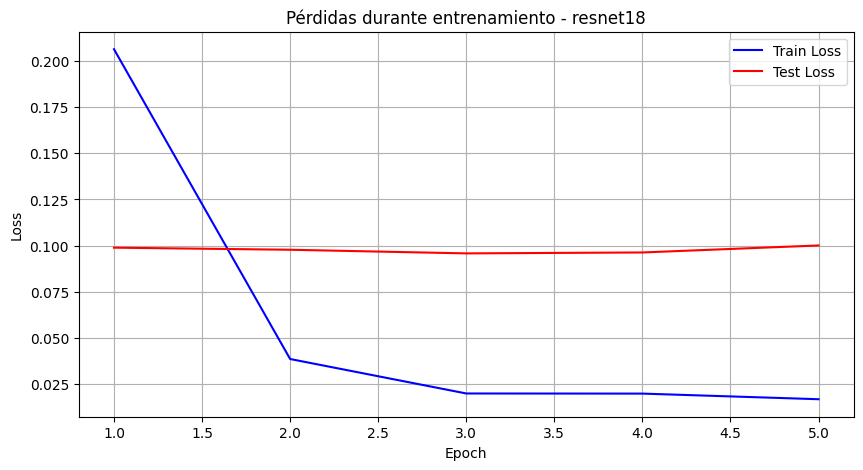


Pérdidas por época para resnet18:
 Epoch 1: Train Loss=0.2064, Test Loss=0.0989
 Epoch 2: Train Loss=0.0386, Test Loss=0.0978
 Epoch 3: Train Loss=0.0199, Test Loss=0.0958
 Epoch 4: Train Loss=0.0198, Test Loss=0.0963
 Epoch 5: Train Loss=0.0168, Test Loss=0.1001

=== Entrenando y evaluando: densenet121 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 202MB/s]


Epoch 1/5


Eval: 100%|██████████| 85/85 [00:28<00:00,  3.00it/s]


Train Loss: 0.1799 | Test Loss: 0.0783
Epoch 2/5


Eval: 100%|██████████| 85/85 [00:28<00:00,  2.95it/s]


Train Loss: 0.0266 | Test Loss: 0.0713
Epoch 3/5


Eval: 100%|██████████| 85/85 [00:27<00:00,  3.09it/s]


Train Loss: 0.0155 | Test Loss: 0.0648
Epoch 4/5


Eval: 100%|██████████| 85/85 [00:28<00:00,  3.03it/s]


Train Loss: 0.0126 | Test Loss: 0.0815
Epoch 5/5


Eval: 100%|██████████| 85/85 [00:28<00:00,  2.96it/s]


Train Loss: 0.0179 | Test Loss: 0.0671
Modelo guardado: triplet_model_densenet121.pth
[+] Evaluando métricas de clasificación...


Clasificando test set: 100%|██████████| 1357/1357 [00:30<00:00, 44.73it/s]



=== MÉTRICA DE CLASIFICACIÓN ===
Accuracy: 0.9307

=== REPORTE POR CLASE ===
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.95      0.96      0.95       119
  apu_nahasapeemapetilon       0.98      0.98      0.98        42
            bart_simpson       1.00      0.98      0.99       111
charles_montgomery_burns       0.90      0.88      0.89       130
            chief_wiggum       1.00      0.98      0.99        42
          comic_book_guy       0.90      0.83      0.86        42
          edna_krabappel       0.93      0.93      0.93        43
           homer_simpson       0.93      0.93      0.93       123
           kent_brockman       0.95      0.86      0.90        43
        krusty_the_clown       0.95      0.91      0.93        46
            lisa_simpson       0.90      0.89      0.90       113
           marge_simpson       0.95      0.99      0.97       112
     milhouse_van_houten       1.00      0.86      0.92        

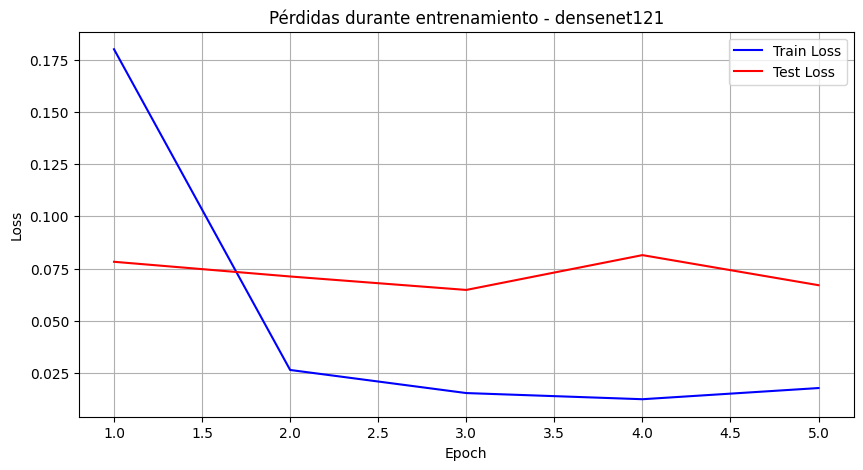


Pérdidas por época para densenet121:
 Epoch 1: Train Loss=0.1799, Test Loss=0.0783
 Epoch 2: Train Loss=0.0266, Test Loss=0.0713
 Epoch 3: Train Loss=0.0155, Test Loss=0.0648
 Epoch 4: Train Loss=0.0126, Test Loss=0.0815
 Epoch 5: Train Loss=0.0179, Test Loss=0.0671

=== Entrenando y evaluando: efficientnet_b0 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


Epoch 1/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.75it/s]


Train Loss: 0.3589 | Test Loss: 0.1267
Epoch 2/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.76it/s]


Train Loss: 0.0633 | Test Loss: 0.0981
Epoch 3/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.76it/s]


Train Loss: 0.0258 | Test Loss: 0.0861
Epoch 4/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.79it/s]


Train Loss: 0.0145 | Test Loss: 0.0807
Epoch 5/5


Eval: 100%|██████████| 85/85 [00:22<00:00,  3.80it/s]


Train Loss: 0.0107 | Test Loss: 0.0807
Modelo guardado: triplet_model_efficientnet_b0.pth
[+] Evaluando métricas de clasificación...


Clasificando test set: 100%|██████████| 1357/1357 [00:17<00:00, 77.00it/s]



=== MÉTRICA DE CLASIFICACIÓN ===
Accuracy: 0.9219

=== REPORTE POR CLASE ===
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.95      0.97       119
  apu_nahasapeemapetilon       1.00      0.98      0.99        42
            bart_simpson       0.97      0.96      0.97       111
charles_montgomery_burns       0.89      0.90      0.89       130
            chief_wiggum       0.95      0.90      0.93        42
          comic_book_guy       0.77      0.81      0.79        42
          edna_krabappel       0.83      0.93      0.88        43
           homer_simpson       0.93      0.93      0.93       123
           kent_brockman       0.95      0.86      0.90        43
        krusty_the_clown       0.93      0.91      0.92        46
            lisa_simpson       0.78      0.93      0.85       113
           marge_simpson       1.00      0.98      0.99       112
     milhouse_van_houten       0.85      0.93      0.89        

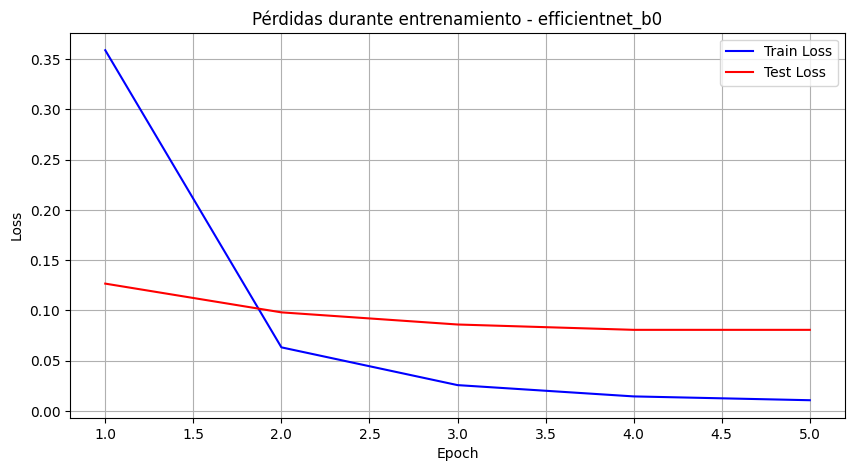


Pérdidas por época para efficientnet_b0:
 Epoch 1: Train Loss=0.3589, Test Loss=0.1267
 Epoch 2: Train Loss=0.0633, Test Loss=0.0981
 Epoch 3: Train Loss=0.0258, Test Loss=0.0861
 Epoch 4: Train Loss=0.0145, Test Loss=0.0807
 Epoch 5: Train Loss=0.0107, Test Loss=0.0807

COMPARACIÓN FINAL DE MODELOS

RESNET18:
  Accuracy: 0.9086

DENSENET121:
  Accuracy: 0.9307

EFFICIENTNET_B0:
  Accuracy: 0.9219

🏆 MEJOR MODELO: DENSENET121
   Accuracy: 0.9307


In [ ]:

if __name__ == "__main__":
    # Configuración
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    root_dir = 'simpsons_dataset'
    annotation_txt = 'annotation.txt'

    # Paso 1: dividir anotaciones
    split_annotations(
        annotation_path=annotation_txt,
        root_dir=root_dir,
        train_output='annotations_train.csv',
        test_output='annotations_test.csv',
        test_size=0.2
    )

    # Paso 2: generar tripletas mejoradas (todas las clases como anchor)
    print("\n=== Generando tripletas mejoradas ===")
    generate_triplets_from_annotation_csv_improved(
        'annotations_train.csv', 'triplets_train.csv', triplets_per_anchor=3
    )
    generate_triplets_from_annotation_csv_improved(
        'annotations_test.csv', 'triplets_test.csv', triplets_per_anchor=2
    )

    ### Paso 3: entrenar y evaluar cada modelo
    backbones = ['resnet18', 'densenet121', 'efficientnet_b0']
    results = {}

    for backbone in backbones:
        model, metrics, train_losses, test_losses = train_and_evaluate_model(
            backbone=backbone,
            train_csv='triplets_train.csv',
            test_csv='triplets_test.csv',
            device=device,
            epochs=5
        )
        results[backbone] = metrics

        # Imprimir pérdidas
        print(f"\nPérdidas por época para {backbone}:")
        for epoch, (tloss, vloss) in enumerate(zip(train_losses, test_losses), 1):
            print(f" Epoch {epoch}: Train Loss={tloss:.4f}, Test Loss={vloss:.4f}")

    #Comparar modelos
    print("\n" + "="*60)
    print("COMPARACIÓN FINAL DE MODELOS")
    print("="*60)

    for backbone, metrics in results.items():
        print(f"\n{backbone.upper()}:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")

    #Encontrar mejor modelo
    best_backbone = max(results.keys(), key=lambda x: results[x]['accuracy'])
    print(f"\n🏆 MEJOR MODELO: {best_backbone.upper()}")
    print(f"   Accuracy: {results[best_backbone]['accuracy']:.4f}")

###  Función para cargar el modelo entrenado
Carga los pesos de un modelo previamente entrenado.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import torchvision.models as models

def load_trained_model(model_path, backbone='resnet18', embedding_size=128, device='cpu'):
    """
    Carga un modelo entrenado desde archivo
    """
    model = EmbeddingNet(backbone=backbone, embedding_size=embedding_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Obtener imagen aleatoria

Función para seleccionar una imagen aleatoria del dataset

In [ ]:
def get_random_image_from_dataset(annotation_csv):
    """
    Selecciona una imagen aleatoria del dataset
    """
    df = pd.read_csv(annotation_csv)
    random_idx = random.randint(0, len(df) - 1)
    row = df.iloc[random_idx]

    return {
        'path': row['path'],
        'bbox': row['bbox'],
        'true_label': row['label']
    }

# Preprocesamiento de imagen
Función para procesar una imagen aplicando la bounding box y transformaciones

In [ ]:
def preprocess_image(image_path, bbox_str, transform):
    """
    Procesa una imagen aplicando bounding box y transformaciones
    """
    try:
        # Cargar imagen
        img = Image.open(image_path).convert('RGB')

        # Aplicar bounding box
        bbox = list(map(int, bbox_str.split(',')))
        x1, y1, x2, y2 = bbox

        # Asegurar orden correcto de coordenadas
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)

        # Recortar imagen
        cropped_img = img.crop((x1, y1, x2, y2))

        # Aplicar transformaciones
        if transform:
            tensor_img = transform(cropped_img)
        else:
            tensor_img = transforms.ToTensor()(cropped_img)

        return cropped_img, tensor_img

    except Exception as e:
        print(f"Error procesando imagen {image_path}: {e}")
        return None, None

# Predicción de personaje
Función para predecir el personaje más probable

In [ ]:
def predict_character(model, image_tensor, reference_embeddings, device):
    """
    Predice el personaje usando el modelo entrenado
    """
    model.eval()
    with torch.no_grad():
        # Obtener embedding de la imagen
        image_tensor = image_tensor.unsqueeze(0).to(device)
        embedding = model(image_tensor).cpu().numpy()

        # Calcular distancias con embeddings de referencia
        distances = {}
        for ref_label, ref_emb in reference_embeddings.items():
            distance = np.linalg.norm(embedding - ref_emb)
            distances[ref_label] = distance

        # Ordenar por distancia (menor distancia = más similar)
        sorted_predictions = sorted(distances.items(), key=lambda x: x[1])

        return sorted_predictions

# Visualización de resultados
Visualización de la imagen y las top-5 predicciones

In [ ]:
def visualize_prediction(image, true_label, predictions, top_k=5):
    """
    Visualiza la imagen y las predicciones
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Mostrar imagen
    ax1.imshow(image)
    ax1.set_title(f'Imagen Original\nEtiqueta Real: {true_label}', fontsize=12)
    ax1.axis('off')

    # Mostrar predicciones
    labels = [pred[0] for pred in predictions[:top_k]]
    distances = [pred[1] for pred in predictions[:top_k]]

    # Crear gráfico de barras horizontal
    y_pos = np.arange(len(labels))
    bars = ax2.barh(y_pos, distances)

    # Colorear la barra de la predicción correcta
    predicted_label = predictions[0][0]
    if predicted_label == true_label:
        bars[0].set_color('green')
        bars[0].set_alpha(0.8)
    else:
        bars[0].set_color('red')
        bars[0].set_alpha(0.8)

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.invert_yaxis()
    ax2.set_xlabel('Distancia Euclidiana')
    ax2.set_title(f'Top {top_k} Predicciones\nPredicción: {predicted_label}', fontsize=12)
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return predicted_label == true_label

# Predicción sobre una imagen aleatoria
Función principal para predecir sobre una imagen aleatoria

In [ ]:
def predict_random_image(model_path, annotation_csv, reference_embeddings,
                        backbone='resnet18', embedding_size=128, device='cpu'):
    """
    Función principal para predecir una imagen aleatoria
    """
    # Configurar transformaciones
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Cargar modelo
    print("Cargando modelo...")
    model = load_trained_model(model_path, backbone, embedding_size, device)

    # Seleccionar imagen aleatoria
    print("Seleccionando imagen aleatoria...")
    random_image_info = get_random_image_from_dataset(annotation_csv)

    print(f"Imagen seleccionada: {random_image_info['path']}")
    print(f"Etiqueta real: {random_image_info['true_label']}")

    # Procesar imagen
    cropped_img, tensor_img = preprocess_image(
        random_image_info['path'],
        random_image_info['bbox'],
        transform
    )

    if cropped_img is None:
        print("Error al procesar la imagen")
        return None

    # Hacer predicción
    print("Realizando predicción...")
    predictions = predict_character(model, tensor_img, reference_embeddings, device)

    # Visualizar resultados
    is_correct = visualize_prediction(
        cropped_img,
        random_image_info['true_label'],
        predictions
    )

    # Mostrar resultados en texto
    print(f"\n{'='*50}")
    print(f"RESULTADOS DE PREDICCIÓN")
    print(f"{'='*50}")
    print(f"Etiqueta real: {random_image_info['true_label']}")
    print(f"Predicción: {predictions[0][0]}")
    print(f"Distancia: {predictions[0][1]:.4f}")
    print(f"¿Correcta?: {'✅ SÍ' if is_correct else '❌ NO'}")

    print(f"\nTop 5 predicciones:")
    for i, (label, distance) in enumerate(predictions[:5]):
        print(f"{i+1}. {label}: {distance:.4f}")

    return {
        'true_label': random_image_info['true_label'],
        'predicted_label': predictions[0][0],
        'distance': predictions[0][1],
        'is_correct': is_correct,
        'all_predictions': predictions,
        'image_path': random_image_info['path']
    }


## Predicción múltiple (evaluación por lotes)
Función para realizar múltiples predicciones aleatorias

In [ ]:
def test_multiple_random_predictions(model_path, annotation_csv, reference_embeddings,
                                   num_tests=10, backbone='resnet18', embedding_size=128, device='cpu'):
    """
    Realiza múltiples predicciones aleatorias para evaluar el rendimiento
    """
    results = []
    correct_predictions = 0

    print(f"Realizando {num_tests} predicciones aleatorias...")

    for i in range(num_tests):
        print(f"\n--- Predicción {i+1}/{num_tests} ---")
        result = predict_random_image(
            model_path, annotation_csv, reference_embeddings,
            backbone, embedding_size, device
        )

        if result:
            results.append(result)
            if result['is_correct']:
                correct_predictions += 1

    # Mostrar estadísticas finales
    accuracy = correct_predictions / len(results) if results else 0
    print(f"\n{'='*60}")
    print(f"ESTADÍSTICAS FINALES")
    print(f"{'='*60}")
    print(f"Total de predicciones: {len(results)}")
    print(f"Predicciones correctas: {correct_predictions}")
    print(f"Accuracy: {accuracy:.2%}")

    return results

# Función principal (una predicción)
Ejecutar predicción de una sola imagen

In [ ]:
# Código completo para ejecutar predicciones
def run_random_prediction_complete():
    """
    Función completa para ejecutar predicción en imagen aleatoria
    """
    # Configuración
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    # Configurar transformaciones (deben ser las mismas del entrenamiento)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Cargar el mejor modelo (ajusta el nombre según tu modelo entrenado)
    model_path = 'triplet_model_resnet18.pth'  # Cambia por tu modelo
    model = load_trained_model(model_path, 'resnet18', 128, device)

    # Generar embeddings de referencia
    print("Generando embeddings de referencia...")
    reference_embeddings, class_labels = compute_reference_embeddings(
        model, 'annotations_train.csv', transform, device, samples_per_class=5
    )

    print(f"Clases disponibles: {class_labels}")
    print(f"Total de clases: {len(class_labels)}")

    # Realizar predicción en imagen aleatoria
    print("\n" + "="*50)
    print("PREDICCIÓN EN IMAGEN ALEATORIA")
    print("="*50)

    result = predict_random_image(
        model_path='triplet_model_resnet18.pth',
        annotation_csv='annotations_test.csv',
        reference_embeddings=reference_embeddings,
        backbone='resnet18',
        embedding_size=128,
        device=device
    )

    return result

# Función principal (múltiples predicciones)
Ejecutar múltiples predicciones aleatorias

In [ ]:
def run_multiple_predictions():
    """
    Ejecuta múltiples predicciones para evaluar el rendimiento
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Configurar transformaciones
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Cargar modelo y generar embeddings de referencia
    model_path = 'triplet_model_resnet18.pth'
    model = load_trained_model(model_path, 'resnet18', 128, device)

    reference_embeddings, class_labels = compute_reference_embeddings(
        model, 'annotations_train.csv', transform, device
    )

    # Realizar múltiples predicciones
    results = test_multiple_random_predictions(
        model_path=model_path,
        annotation_csv='annotations_test.csv',
        reference_embeddings=reference_embeddings,
        num_tests=5,  # Cambia este número para más o menos pruebas
        backbone='resnet18',
        device=device
    )

    return results


# Ejecutar código main
###  Ejecución de prueba del sistema completo
Descomenta una de las siguientes líneas para probar el sistema de predicción.

Para predecir una sola imagen aleatoria:
`result = run_random_prediction_complete()`

Para predecir múltiples imágenes:
`results = run_multiple_predictions()`

In [ ]:
if __name__ == "__main__":
    # Descomenta la línea que quieras ejecutar:

    # Para una sola predicción:
    result = run_random_prediction_complete()

    # Para múltiples predicciones:
    #results = run_multiple_predictions()

    print("Ejecuta las funciones run_random_prediction_complete() o run_multiple_predictions()")


INSTRUCCIONES DE USO:

1. Primero ejecuta tu código de entrenamiento completo
2. Asegúrate de que tienes los archivos:
   - triplet_model_resnet18.pth (o el nombre de tu modelo)
   - annotations_train.csv
   - annotations_test.csv

3. Para predecir UNA imagen aleatoria:
   result = run_random_prediction_complete()

4. Para predecir MÚLTIPLES imágenes aleatorias:
   results = run_multiple_predictions()

5. Las funciones mostrarán:
   - La imagen recortada
   - Las top 5 predicciones con distancias
   - Si la predicción fue correcta o no
   - Estadísticas de accuracy

Usando dispositivo: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


FileNotFoundError: [Errno 2] No such file or directory: 'triplet_model_resnet18.pth'